<span style='color:Blue ;
             font-size:30px;'>
    Свёрточная нейронная сеть.  </span><br>

#### Importing libraries and selecting the device

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import F1Score
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\Amir\anaconda3\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


cuda:0


<span style='color:Blue ;
             font-size:20px;'>
    Task 1.  </span><br>

**Main goal of Task 1:** Implementation a traffic sign classification convolutional neural network which
will be trained on German Traffic Sign Recognition Benchmark dataset. <br>
<br>

**Task 1 steps:** <br>
    **a) Loading dataset:** <br>
    The uploaded dataset containing photos of road signs consists of 43 classes related to the type of road signs. <br>
   **b) Setting up TensorBoard:** <br>
    An object of class SummaryWriter from torch.utils.tensorboard was created. <br>
    **c) Splitting the data Training (70%) and validation (10%) and Testing (20%):** <br>
    The loaded dataset was split into train, test and validation with the shapes specified in the task. For verification, their percentages were calculated. <br>
    **d) Creating Data loaders:** <br>
    Train,validation and test images were successfully converted the to tensors. <br>
    **e) Data visualization:** <br>
    For example, 4 images were plotted.<br>
    **f) Building a baseline CNN model:** <br>
    The base line model is to be trained on 20 epochs, SGD optimizer, learning rate 0.001. The architecture of the CNN was specified in the task. <br>
    **g) Training and metrics calculation:** <br>
    During the training, the accuracy and f1-score were calculated on the train and validation dataset. Also the data was uploaded to tensorboard. After 20 epochs, the model was tested on a test dataset. Values of the selected metrics: <br>
    Train: Acc= 94.7%  F1 = 94.7% <br>
    Val: Acc= 90.8%  F1 = 90.7% <br>
    Test: Acc= 91.3%  F1 = 91.4% <br>
    **h) Building an improved CNN model:** <br>
    The following functions have been almost randomly added to the architecture of baseline CNN, but Adam optimizer was selected instead of Stochastic gradient descent: <br>
    1)nn.Dropout2d() - A regularization method in machine learning where the randomly selected neurons are dropped from the neural network to avoid overfitting <br>
    2)nn.ReLU() - The most commonly used activation function in ML, which makes the layers as non-linear layers. <br>
    3)nn.BatchNorm2d() - Accelerate Deep Network training by reducing internal covariate shift. <br>
    **i) Training and metrics calculation:** <br>
    During the training, the accuracy and f1-score were calculated on the train and validation dataset. Also the data was uploaded to tensorboard. After 20 epochs, the model was tested on a test dataset. Values of the selected metrics: <br>
    Train: Acc= 99.1%  F1 = 99.0% <br>
    Val: Acc= 98.1%  F1 = 97.9% <br>
    Test: Acc= 97.8%  F1 = 97.8% <br>

#### Loading dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([32,32]),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.GTSRB(root='./data', download=True, split='train', transform=transform)
class_indices = [i for i in range(43)]

#### Splitting the data Training (70%) and validation (10%) and Testing (20%)

In [3]:
train_data,val_data,test_data =  random_split(dataset, [0.7, 0.1, 0.2])
Data_length = len(train_data) + len(val_data) + len(test_data)
print("Data length : " , Data_length)
print("Train data percentage : ", int(len(train_data)/Data_length*100),"%")
print("Val data percentage : ", int(len(val_data)/Data_length*100),"%")
print("Test data percentage : ", int(len(test_data)/Data_length*100) ,"%")

Data length :  26640
Train data percentage :  70 %
Val data percentage :  10 %
Test data percentage :  20 %


#### Creating Data loaders

In [4]:
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#### Data visualization

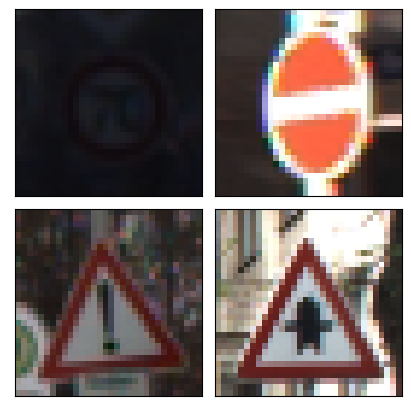

In [5]:
def convert_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return npimg,np.transpose(npimg, (1, 2, 0))

fig = plt.figure(constrained_layout = True, figsize=(4, 4))
axes = fig.subplots(nrows=2, ncols=2)
for row in axes:
    for col in row:
        images, labels = next(iter(train_loader))
        col.imshow(convert_image(torchvision.utils.make_grid(images[:1]))[1])
        col.set_xticks([])
        col.set_yticks([])

#### Building a baseline CNN model

In [6]:
class baseline_CNN(nn.Module):
    def __init__(self):
        super(baseline_CNN, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.Conv2d(32,32,3,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.Conv2d(64,64,3,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1),
            nn.Conv2d(128,128,3,padding=1),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.Linear(512,43)
            )

    def forward(self, x):
        return self.network(x)

#### Training and metrics calculation 

In [7]:
class model_implementation:
    def __init__(self,model,criterion,optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
    
    def training(self, val_loader, model_name, EPOCHS, writer):
        """Function for model training"""
        for epoch in range(EPOCHS):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
            #Calculate and print metrics to estimate performance of our models
            print('Epoch %d, loss: %.6f' %
                  (epoch + 1, running_loss/len(train_loader)))
            train_metrics = self.prediction(train_loader)
            val_metrics = self.prediction(val_loader)
            print("Train:\t Acc= %.1f" % train_metrics[0],"%" , " F1 = %.1f" % train_metrics[1],"%")
            print("Val:\t Acc= %.1f" % val_metrics[0],"%" , " F1 = %.1f" % val_metrics[1],"%")
            
            # log the epoch loss
            writer.add_scalar('training loss',
                            running_loss/len(train_loader),
                            epoch)
            # log the epoch accuracy and f1 of train
            writer.add_scalar('training accuracy',
                            train_metrics[0],
                            epoch)
            writer.add_scalar('training f1',
                            train_metrics[1],
                            epoch)   
            # log the epoch accuracy and f1 of validation
            writer.add_scalar('val accuracy',
                            val_metrics[0],
                            epoch)
            writer.add_scalar('val f1',
                            val_metrics[1],
                            epoch) 
            
    def prediction(self,loader):
        """Function for predict signs and metrics calculation"""
        f1_metric = F1Score(task="multiclass", average='weighted', num_classes=43).to(device)
        correct = 0
        total = 0
        f1 = 0
        with torch.no_grad():
            for data in loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                f1 += f1_metric(predicted, labels) * 100
        f1 /= len(loader)
        accuracy = 100 * correct / total
        return accuracy,f1       

In [8]:
#Writer:
writer = SummaryWriter('runs/Task2/Baseline')
#Model initialization:
model = baseline_CNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Training model:
Baseline_CNN = model_implementation(model,criterion,optimizer)
Baseline_CNN.training(val_loader,'baseline',EPOCHS=20,writer=writer)
#Testing model:
test_metrics = Baseline_CNN.prediction(test_loader)
print("\nTest:\t Acc= %.1f" % test_metrics[0],"%", " F1 = %.1f" % test_metrics[1],"%")

Epoch 1, loss: 3.745251
Train:	 Acc= 8.1 %  F1 = 1.7 %
Val:	 Acc= 7.9 %  F1 = 1.5 %
Epoch 2, loss: 3.693370
Train:	 Acc= 6.6 %  F1 = 2.0 %
Val:	 Acc= 6.6 %  F1 = 1.9 %
Epoch 3, loss: 3.520769
Train:	 Acc= 6.9 %  F1 = 2.3 %
Val:	 Acc= 6.8 %  F1 = 2.1 %
Epoch 4, loss: 3.438440
Train:	 Acc= 10.1 %  F1 = 4.8 %
Val:	 Acc= 10.3 %  F1 = 4.6 %
Epoch 5, loss: 3.342886
Train:	 Acc= 12.4 %  F1 = 8.9 %
Val:	 Acc= 11.6 %  F1 = 7.9 %
Epoch 6, loss: 3.253808
Train:	 Acc= 14.8 %  F1 = 10.2 %
Val:	 Acc= 13.7 %  F1 = 9.1 %
Epoch 7, loss: 3.120185
Train:	 Acc= 19.3 %  F1 = 16.3 %
Val:	 Acc= 18.1 %  F1 = 14.9 %
Epoch 8, loss: 2.838965
Train:	 Acc= 29.7 %  F1 = 26.5 %
Val:	 Acc= 28.6 %  F1 = 25.9 %
Epoch 9, loss: 2.315170
Train:	 Acc= 43.7 %  F1 = 42.4 %
Val:	 Acc= 42.8 %  F1 = 42.0 %
Epoch 10, loss: 1.759129
Train:	 Acc= 54.8 %  F1 = 52.3 %
Val:	 Acc= 53.5 %  F1 = 51.3 %
Epoch 11, loss: 1.356889
Train:	 Acc= 64.6 %  F1 = 63.9 %
Val:	 Acc= 62.6 %  F1 = 61.0 %
Epoch 12, loss: 1.032706
Train:	 Acc= 72.2 %  F

#### Building an improved CNN model

In [9]:
class improved_CNN(nn.Module):
    def __init__(self):
        super(improved_CNN, self).__init__()
        self.network=nn.Sequential(            
            nn.Conv2d(3,32,3,padding=1),
            nn.Dropout2d(0.25),
            nn.ReLU(),
            
            nn.Conv2d(32,32,3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.25),
            nn.ReLU(),
            
            nn.Conv2d(64,64,3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.25),
            nn.ReLU(),
            
            nn.Conv2d(128,128,3,padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2,2),
            nn.Flatten(),
            
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(4096, 2048),
            nn.ReLU(),
            
            nn.Linear(2048, 1024),
            nn.ReLU(),
              
            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512,43)
            )

    def forward(self, x):
        return self.network(x)

In [10]:
#Writer:
writer = SummaryWriter('runs/Task2/Imroved')
#Model initialization:
Model_improved = improved_CNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(Model_improved.parameters(), lr=0.001)

#Training model:
Improved_CNN = model_implementation(Model_improved,criterion,optimizer)
Improved_CNN.training(val_loader,'improved',EPOCHS=20,writer=writer)

#Testing model:
test_metrics = Improved_CNN.prediction(test_loader)
print("\nTest:\t Acc= %.1f" % test_metrics[0],"%", " F1 = %.1f" % test_metrics[1],"%")

Epoch 1, loss: 3.383790
Train:	 Acc= 15.9 %  F1 = 8.0 %
Val:	 Acc= 15.5 %  F1 = 7.6 %
Epoch 2, loss: 1.925690
Train:	 Acc= 54.0 %  F1 = 48.8 %
Val:	 Acc= 53.0 %  F1 = 48.0 %
Epoch 3, loss: 0.875061
Train:	 Acc= 80.7 %  F1 = 78.9 %
Val:	 Acc= 79.5 %  F1 = 78.0 %
Epoch 4, loss: 0.393075
Train:	 Acc= 90.8 %  F1 = 90.5 %
Val:	 Acc= 89.4 %  F1 = 89.2 %
Epoch 5, loss: 0.215287
Train:	 Acc= 95.8 %  F1 = 95.7 %
Val:	 Acc= 94.6 %  F1 = 94.7 %
Epoch 6, loss: 0.147957
Train:	 Acc= 96.2 %  F1 = 96.2 %
Val:	 Acc= 94.6 %  F1 = 94.6 %
Epoch 7, loss: 0.102265
Train:	 Acc= 97.2 %  F1 = 97.2 %
Val:	 Acc= 96.2 %  F1 = 96.2 %
Epoch 8, loss: 0.091801
Train:	 Acc= 97.7 %  F1 = 97.7 %
Val:	 Acc= 96.3 %  F1 = 96.5 %
Epoch 9, loss: 0.078184
Train:	 Acc= 98.8 %  F1 = 98.8 %
Val:	 Acc= 97.7 %  F1 = 97.7 %
Epoch 10, loss: 0.057499
Train:	 Acc= 98.6 %  F1 = 98.6 %
Val:	 Acc= 97.7 %  F1 = 97.6 %
Epoch 11, loss: 0.063765
Train:	 Acc= 99.0 %  F1 = 99.0 %
Val:	 Acc= 97.6 %  F1 = 97.7 %
Epoch 12, loss: 0.037180
Train:	

***Conclusion of Task 1:*** CNN models with different architectures were built and compared with each other. Based on the obtained metric values, it can be judged that the improved model trains faster, and thus achieves higher accuracy and f1-points. I would also like to note the influence of the ***batch size*** hyperparameter on the process of model training. With its high value, the model trains faster, but shows a slightly lower result.
    <br>

<span style='color:Blue ;
             font-size:20px;'>
    Task 2.  </span><br>

**Main goal of Task 2:** Complete the goal of the previous task using transfer learning approach with parameters reduced loaded neural network. <br>
<br>

**Task 2 steps:** <br>
    **a,b,c,d,e)** See previous task :)   
    **f) Loading a pre-trained model:** <br>
    To accomplish the task, the Alexnet neural network was used.The 2012 ImageNet winner achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up.<br>
    **g) Building a transfer learning model:** <br>
    To apply the loaded neural network, the dimensions of fully-connected layers have been changed.<br>
    **h) Сhanging the architecture of the loaded neural network for better model performance:** <br>
    The number of fully-connected layers has been reduced to one. However, the model achieved higher accuracy. Therefore, Dropout was added in addition, which made it possible to reduce the accuracy of the model.
    **h) Training and metrics calculation:** <br>
    During the training, the accuracy and f1-score were calculated on the train and validation dataset. Also the data was uploaded to tensorboard. After 10 epochs, the model was tested on a test dataset. Values of the selected metrics: <br>
    *Default AlexNet:*<br>
    Train: Acc= 97.5%  F1 = 97.4% <br>
    Val: Acc= 95.5%  F1 = 95.5% <br>
    Test: Acc= 95.3%  F1 = 95.1% <br>
    *Reduced AlexNet:*<br>
    Train: Acc= 93.0%  F1 = 93.0% <br>
    Val: Acc= 90.4%  F1 = 90.9% <br>
    Test: Acc= 90.8%  F1 = 90.8% <br> 
    **i) Comparison of models:** <br>
    The obtained data of the parameters of neural networks and the necessary metrics were recorded in the Dataframe. As you can see, the number of parameters has decreased by a factor of 20, while the accuracy of the model has fallen by less than 5%.<br>

#### Loading a pre-trained model

In [11]:
Alexnet_default = models.alexnet(pretrained=True)
Alexnet_default.eval()

C:\Users\Amir\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amir\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Amir/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:15<00:00, 15.6MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Creating identity class for mute layers in network

In [12]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

#### Building a transfer learning models with defaul and reduced parameters:

In [13]:
#Initialization reduced model
Alexnet_reduced = models.alexnet(pretrained=True)
Alexnet_reduced.eval()
#spike
Alexnet_default.features[2] = Identity()
Alexnet_reduced.features[2] = Identity()
#Updating the last classifier that is the output layer of the network
Alexnet_default.classifier[6] = nn.Linear(4096,43)
Alexnet_reduced.classifier[6] = nn.Linear(1024,43)

#Reduce number of hidden units in default model to reduce parameters:
Alexnet_reduced.classifier[1] = nn.Linear(9216,43)
Alexnet_reduced.classifier[2] = Identity()
Alexnet_reduced.classifier[4] = Identity()
Alexnet_reduced.classifier[5] = Identity()
Alexnet_reduced.classifier[6] = Identity()

Alexnet_reduced.features[1] = nn.Dropout(p=0.08, inplace=False)

#Switch to CUDA:
Alexnet_default = Alexnet_default.to(device)
Alexnet_reduced = Alexnet_reduced.to(device)

#### Default model evaluating

In [14]:
#Writer:
writer = SummaryWriter('runs/Task2_2/Default')
#Model criterion and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(Alexnet_default.parameters(), lr=0.001)

#Training default model:
Transfer_CNN = model_implementation(Alexnet_default,criterion,optimizer)
Transfer_CNN.training(val_loader,'transfer',EPOCHS=10,writer=writer)

#Testing model:
test_metrics = Transfer_CNN.prediction(test_loader)
print("\nTest:\t Acc= %.1f" % test_metrics[0],"%", " F1 = %.1f" % test_metrics[1],"%")

Epoch 1, loss: 1.496027
Train:	 Acc= 82.0 %  F1 = 81.6 %
Val:	 Acc= 80.3 %  F1 = 80.1 %
Epoch 2, loss: 0.410610
Train:	 Acc= 90.4 %  F1 = 90.1 %
Val:	 Acc= 88.6 %  F1 = 88.1 %
Epoch 3, loss: 0.249575
Train:	 Acc= 94.3 %  F1 = 94.2 %
Val:	 Acc= 91.8 %  F1 = 91.8 %
Epoch 4, loss: 0.183656
Train:	 Acc= 96.7 %  F1 = 96.8 %
Val:	 Acc= 95.0 %  F1 = 95.2 %
Epoch 5, loss: 0.126554
Train:	 Acc= 97.1 %  F1 = 97.1 %
Val:	 Acc= 95.1 %  F1 = 95.0 %
Epoch 6, loss: 0.146982
Train:	 Acc= 92.5 %  F1 = 92.0 %
Val:	 Acc= 89.8 %  F1 = 89.0 %
Epoch 7, loss: 0.196281
Train:	 Acc= 94.7 %  F1 = 94.6 %
Val:	 Acc= 93.0 %  F1 = 92.9 %
Epoch 8, loss: 0.128201
Train:	 Acc= 96.0 %  F1 = 95.9 %
Val:	 Acc= 94.2 %  F1 = 94.2 %
Epoch 9, loss: 0.110189
Train:	 Acc= 96.7 %  F1 = 96.7 %
Val:	 Acc= 95.6 %  F1 = 95.7 %
Epoch 10, loss: 0.101255
Train:	 Acc= 98.4 %  F1 = 98.4 %
Val:	 Acc= 97.0 %  F1 = 97.1 %

Test:	 Acc= 96.8 %  F1 = 96.9 %


#### Reduced model evaluating

In [15]:
#Writer:
writer = SummaryWriter('runs/Task2_2/Reduced')
#Model criterion and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(Alexnet_reduced.parameters(), lr=0.001)

#Training default model:
Reduced_CNN = model_implementation(Alexnet_reduced,criterion,optimizer)
Reduced_CNN.training(val_loader,'transfer',EPOCHS=10,writer=writer)

#Testing model:
test_metrics = Reduced_CNN.prediction(test_loader)
print("\nTest:\t Acc= %.1f" % test_metrics[0],"%", " F1 = %.1f" % test_metrics[1],"%")

Epoch 1, loss: 3.514151
Train:	 Acc= 11.9 %  F1 = 6.2 %
Val:	 Acc= 12.1 %  F1 = 5.9 %
Epoch 2, loss: 3.258506
Train:	 Acc= 19.0 %  F1 = 14.0 %
Val:	 Acc= 18.9 %  F1 = 14.0 %
Epoch 3, loss: 2.221596
Train:	 Acc= 43.2 %  F1 = 37.0 %
Val:	 Acc= 41.7 %  F1 = 35.8 %
Epoch 4, loss: 1.272762
Train:	 Acc= 65.4 %  F1 = 62.0 %
Val:	 Acc= 63.6 %  F1 = 60.6 %
Epoch 5, loss: 0.814632
Train:	 Acc= 80.9 %  F1 = 80.4 %
Val:	 Acc= 79.7 %  F1 = 79.1 %
Epoch 6, loss: 0.430134
Train:	 Acc= 88.2 %  F1 = 87.8 %
Val:	 Acc= 85.4 %  F1 = 84.9 %
Epoch 7, loss: 0.275625
Train:	 Acc= 91.7 %  F1 = 91.3 %
Val:	 Acc= 88.8 %  F1 = 88.3 %
Epoch 8, loss: 0.178225
Train:	 Acc= 92.5 %  F1 = 92.2 %
Val:	 Acc= 90.1 %  F1 = 89.8 %
Epoch 9, loss: 0.187692
Train:	 Acc= 95.1 %  F1 = 95.0 %
Val:	 Acc= 92.3 %  F1 = 92.2 %
Epoch 10, loss: 0.135712
Train:	 Acc= 95.3 %  F1 = 95.3 %
Val:	 Acc= 92.9 %  F1 = 93.0 %

Test:	 Acc= 93.3 %  F1 = 93.3 %


#### Comparison of models

In [16]:
def parameters_counter(model):
    """Function for calculation model parameters"""
    return sum(p.numel() for p in model.parameters())
def metrics(Instance):
    """Function for calculation model accuracy and f1-score"""
    return
#Create a dataframe, containing model performance parameters:
Accuracy_list , F1_list , Param_list = [],[],[]
Models = [Alexnet_default,Alexnet_reduced]
Instances = [Transfer_CNN,Reduced_CNN]
for i in range(2):
    metrics = Instances[i].prediction(test_loader)
    Accuracy_list.append(metrics[0])
    F1_list.append(metrics[1].cpu().detach().numpy())
    Param_list.append(parameters_counter(Models[i]))
 
d = {'Accuracy' : Accuracy_list , 'F1-score' : F1_list, 'Number of parameters' : Param_list}
Metrics_Df = pd.DataFrame(data=d, index=["Default AlexNet"
                                         ,"Reduced AlexNet"])
Metrics_Df.head()

,Accuracy,F1-score,Number of parameters
Default AlexNet,96.828078,96.857895,57180011
Reduced AlexNet,92.905405,92.88863,2866027


***Conclusion of Task 2:*** In conclusion, I would like to note that reducing the parameters does not always lead to a decrease in accuracy, because during the initial runs of the modified model with a reduced number of linear layers, the accuracy only increased. When discarding part of the images for training (dropout), the metrics decreased.

******

**Main goal of Task 1:** Implementation a traffic sign classification convolutional neural network which
will be trained on German Traffic Sign Recognition Benchmark dataset. <br>
<br>
**Task 1 steps:** <br>
    **a) Loading dataset:** <br>
    The uploaded dataset containing photos of road signs consists of 43 classes related to the type of road signs. <br>
   **b) Setting up TensorBoard:** <br>
    An object of class SummaryWriter from torch.utils.tensorboard was created. <br>
    **c) Splitting the data Training (70%) and validation (10%) and Testing (20%):** <br>
    The loaded dataset was split into train, test and validation with the shapes specified in the task. For verification, their percentages were calculated. <br>
    **d) Creating Data loaders:** <br>
    Train,validation and test images were successfully converted the to tensors. <br>
    **e) Data visualization:** <br>
    For example, 4 images were plotted.<br>
    **f) Building a baseline CNN model:** <br>
    The base line model is to be trained on 20 epochs, SGD optimizer, learning rate 0.001. The architecture of the CNN was specified in the task. <br>
    **g) Training and metrics calculation:** <br>
    During the training, the accuracy and f1-score were calculated on the train and validation dataset. Also the data was uploaded to tensorboard. After 20 epochs, the model was tested on a test dataset. Values of the selected metrics: <br>
    Train: Acc= 95.8%  F1 = 95.8% <br>
    Val: Acc= 91.8%  F1 = 91.8% <br>
    Test: Acc= 91.9%  F1 = 91.9% <br>
    **h) Building an improved CNN model:** <br>
    The following functions have been almost randomly added to the architecture of baseline CNN, but Adam optimizer was selected instead of Stochastic gradient descent: <br>
    1)nn.Dropout2d() - A regularization method in machine learning where the randomly selected neurons are dropped from the neural network to avoid overfitting <br>
    2)nn.ReLU() - The most commonly used activation function in ML, which makes the layers as non-linear layers. <br>
    3)nn.BatchNorm2d() - Accelerate Deep Network training by reducing internal covariate shift. <br>
    **i) Training and metrics calculation:** <br>
    During the training, the accuracy and f1-score were calculated on the train and validation dataset. Also the data was uploaded to tensorboard. After 20 epochs, the model was tested on a test dataset. Values of the selected metrics: <br>
    Train: Acc= 98.8%  F1 = 98.8% <br>
    Val: Acc= 97.6%  F1 = 97.6% <br>
    Test: Acc= 97.9%  F1 = 97.9% <br>
    ***Conclusion of Task 1:*** CNN models with different architectures were built and compared with each other. Based on the obtained metric values, it can be judged that the improved model trains faster, and thus achieves higher accuracy and f1-points. I would also like to note the influence of the ***batch size*** hyperparameter on the process of model training. With its high value, the model trains faster, but shows a slightly lower result.
    <br>

**Main goal of Task 2:** Complete the goal of the previous task using transfer learning approach with parameters reduced loaded neural network. <br>
<br>
**Task 2.2 steps:** <br>
    **a,b,c,d,e)** See previous task :)   
    **f) Loading a pre-trained model:** <br>
    To accomplish the task, the Alexnet neural network was used.The 2012 ImageNet winner achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up.<br>
    **g) Building a transfer learning model:** <br>
    To apply the loaded neural network, the dimensions of fully-connected layers have been changed.<br>
    **h) Сhanging the architecture of the loaded neural network for better model performance:** <br>
    The number of fully-connected layers has been reduced to one. However, the model achieved higher accuracy. Therefore, Dropout was added in addition, which made it possible to reduce the accuracy of the model.
    **h) Training and metrics calculation:** <br>
    During the training, the accuracy and f1-score were calculated on the train and validation dataset. Also the data was uploaded to tensorboard. After 10 epochs, the model was tested on a test dataset. Values of the selected metrics: <br>
    *Default AlexNet:*<br>
    Train: Acc= 97.5%  F1 = 97.4% <br>
    Val: Acc= 95.5%  F1 = 95.5% <br>
    Test: Acc= 95.3%  F1 = 95.1% <br>
    *Reduced AlexNet:*<br>
    Train: Acc= 93.0%  F1 = 93.0% <br>
    Val: Acc= 90.4%  F1 = 90.9% <br>
    Test: Acc= 90.8%  F1 = 90.8% <br> 
    **i) Comparison of models:** <br>
    The obtained data of the parameters of neural networks and the necessary metrics were recorded in the Dataframe. As you can see, the number of parameters has decreased by a factor of 20, while the accuracy of the model has fallen by less than 5%.<br>
    ***Conclusion of Task 2:*** In conclusion, I would like to note that reducing the parameters does not always lead to a decrease in accuracy, because during the initial runs of the modified model with a reduced number of linear layers, the accuracy only increased. When discarding part of the images for training (dropout), the metrics decreased.
    <br>